In [1]:

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import io
from tqdm import trange 

In [2]:
##########################################################################
################## Sigmoid function ######################################

def calcSig(inputs, outputs, wGate, wHidden, bias):
    gate = tf.sigmoid(tf.matmul(inputs,wGate) + tf.matmul(outputs,wHidden) + bias)
    return gate
    
##########################################################################

################## LSTM-block function ###################################

def block(inputs, outputs, cell_state, array_of_weights, array_of_bias): # hidden_layers
    inputG = calcSig(inputs, outputs, array_of_weights[0], array_of_weights[1], array_of_bias[0])
    forgetG = calcSig(inputs, outputs, array_of_weights[2], array_of_weights[3], array_of_bias[1])
    outputG = calcSig(inputs, outputs, array_of_weights[4], array_of_weights[5], array_of_bias[2])
    memoryG = calcSig(inputs, outputs, array_of_weights[6], array_of_weights[7], array_of_bias[3])

    cell_state = cell_state * forgetG + inputG * memoryG    # final cell state C
    output_f = tf.tanh(cell_state) * outputG                # final output h

    return cell_state, output_f
    
##########################################################################

class LSTM():
    def __init__(self, batch_size, window_size, hidden_layers, clip_margin, learning_rate, epochs):
        self.batch_size = batch_size
        self.window_size = window_size
        self.hidden_layers = hidden_layers
        self.clip_margin = clip_margin
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.trained_data = []#np.array([]) #np.array([[0 for ii in range(self.batch_size)]for i in range(self.epochs)])
        self.epoch_error = []#np.array([]) 
        ##
        #self.trained_data_np = np.array([])
        ##

        generated_values1 = tf.truncated_normal([1,hidden_layers],stddev = 0.05)
        generated_values2 = tf.truncated_normal([hidden_layers,hidden_layers], stddev = 0.05)
        bias_values = tf.zeros([hidden_layers])

        # Weights
        W_inputG = tf.Variable(generated_values1)       #  weights input gate
        W_inputH = tf.Variable(generated_values2)       #  weights input hidden layer
        W_forgetG = tf.Variable(generated_values1)
        W_forgetH = tf.Variable(generated_values2)
        W_outputG = tf.Variable(generated_values1)
        W_outputH = tf.Variable(generated_values2)
        W_memoryG = tf.Variable(generated_values1)
        W_memoryH = tf.Variable(generated_values2)
        W_Output = tf.Variable(tf.truncated_normal([hidden_layers,1],stddev = 0.05))

        self.array_of_weights = np.array([W_inputG, W_inputH, W_forgetG,W_forgetH,W_outputG,W_outputH, W_memoryG, W_memoryH,W_Output])
       
        
        # Bias
        B_input = tf.Variable(bias_values)
        B_forget = tf.Variable(bias_values)
        B_output = tf.Variable(bias_values)
        B_memory = tf.Variable(bias_values)
        B_Output = tf.Variable(tf.zeros(1))

        self.array_of_bias = np.array([B_input, B_forget, B_output, B_memory, B_Output])

        # Placeholders
        inputs = tf.placeholder(tf.float32,[batch_size,window_size, 1])
        targets = tf.placeholder(tf.float32, [batch_size, 1])

##########################################################################
################## Windowing function ####################################

    def windowed_data(self, data, window_size):
        X = []
        y = []
        i = 0

        while (i + window_size) <= len(data) - 1:
            X.append(data[i:i+window_size])
            
            y.append(data[i+window_size])

            i += 1
        assert len(y) == len(X)
        return X, y
    


################## Loop ######################################
    def loop(self,inputs):
        outputs_h =[]
        for ii in range(batch_size):
            batch_state = np.zeros([1, hidden_layers], dtype=np.float32)
            batch_output = np.zeros([1, hidden_layers], dtype=np.float32)

            for jj in range(window_size): 
                batch_state, batch_output = block(tf.reshape(inputs[ii][jj], (-1,1)), batch_state, batch_output,self.array_of_weights,self.array_of_bias)
                
            outputs_h.append(tf.matmul(batch_output,self.array_of_weights[8]) + self.array_of_bias[4])

        return outputs_h

##################################################################################
###### Looking at the performance by defining the loss by mean squared error #####
    def mseErrors(self,targets,outputs_h):
        errors = []
        a = []

        for ii in range(len(outputs_h)):
            aux_reshape = tf.reshape(targets[ii],(-1,1))
            a = errors.append(tf.losses.mean_squared_error(aux_reshape, outputs_h[ii]))
        error = tf.reduce_mean(errors)
        
        return error
##########################################################################

############################# Training ###################################
    def training(self,X_train, y_train, outputs_h, error):
        print("Calculating the 'optimizer'...")
        optimizer = tf.train.GradientDescentOptimizer(self.learning_rate)
        print("Calculating the 'op'...")
        op = optimizer.minimize(error)
        session = tf.Session()
        session.run(tf.global_variables_initializer())
        print("Going into the loop")
        for ii in range(epochs):
            print("In for-loop:", ii)
            epoch_error = []
            jj = 0
            count = 0
            print("Calculating the 'a,b' from Session.run...")
            while(jj + batch_size) <= len(X_train)/2: # take away /2
                X_batch = X_train[jj:jj + batch_size]
                y_batch = y_train[jj:jj + batch_size]
                
                a, b, _ = session.run([outputs_h, error, op],feed_dict = {inputs:X_batch, targets:y_batch})
                print("size_of_a:", len(a))
                # ERROR HERE 
                self.trained_data.append(a) #np.concatenate((self.trained_data,a), axis=ii) # 
                
                self.epoch_error.append(b) #np.concatenate((self.epoch_error,b), axis=ii)#
                
                jj += batch_size
                count += 1
                print("count, in while-loop:", count)
            
            if (ii % 30) == 0:
                print('Epoch {}/{}'.format(ii,self.epochs),'Current loss {}'.format(np.mean(epoch_error)))


Here is the code for loading of data

In [3]:
############### This might be done in main as well ####################### 
#Loading data and converting it into a .csv file
#data_xls = pd.read_excel('Sarcos.xls', 'Sheet1', index_col=None).astype(np.float32)
#data_xls.to_csv('Sarcos_csv.csv', encoding='utf-8')
#data = pd.read_csv('Sarcos_csv.csv',encoding='utf-8')

####### HERE, LOOP OVER ALL COLUMNS IN THE CSV-FILE AND CONSTRUCT A MATRIX CONTAINING ALL DATA #######
#loaded_data = np.array([[0 for ii in range(data.shape[0])]for i in range(data.shape[1])])
#nr_col_data = data.shape[1]
#for ii in range(nr_col_data):
    
#    data1 = data.iloc[:, ii]  # reading from index 1 in the csv file
#    loaded_data = np.insert(loaded_data,(1,ii),data1)
    #scaler = StandardScaler()
    #scaled_data = scaler.fit_transform(data1.values.reshape(-1, 1))
    
#print("loaded_data:",loaded_data)  
#print("size_of_loaded_data:",loaded_data.shape)


nInputs = 21
nOutputs = 7
split = 0.5
data = np.genfromtxt('Sarcos_csv.csv', delimiter=',')
ind = round(split*data.shape[0])


X_train = data[0:ind,0:nInputs,np.newaxis]
y_train = data[0:ind,1:2] #y_train = data[0:ind,nInputs:,np.newaxis]
X_test = data[ind:,0:nInputs,np.newaxis]
y_test = data[ind:,nInputs:,np.newaxis]

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(X_test.shape))

X_train size: (22242, 21, 1)
y_train size: (22242, 1)
X_test size: (22242, 21, 1)
y_test size: (22242, 21, 1)


In [4]:
############################################################################
# Defining hyperparameters, THEY SHOULD BE MODIFIED, THEY SHOULD BE DEFINED IN main 
batch_size = 20  # number of windows passed at once
window_size = 10  # number of data points we want to predict
hidden_layers = 50  #250, number of hidden layers in the LSTM
clip_margin = 4  # used to clip gradients above/below its margins
learning_rate = 0.0001  # way to optimize the loss function
epochs = 1 #200  # number of iterations the model needs to make (forward and back propagation)

############################################################################
############################################################################
callingClass = LSTM(batch_size,window_size,hidden_layers,clip_margin,learning_rate,epochs)

# Splitting into training and validation data
#X, y = callingClass.windowed_data(scaled_data,window_size)
#size_of_80p = int(len(scaled_data) * 0.8)

#X_train = np.array(X[:size_of_80p])  # we want 80 % to be training data
#y_train = np.array(y[:size_of_80p])

#X_test = np.array(X[size_of_80p:])
#y_test = np.array(y[size_of_80p:])

#print("X_train size: {}".format(X_train.shape))
#print("y_train size: {}".format(y_train.shape))
#print("X_test size: {}".format(X_test.shape))
#print("y_test size: {}".format(X_test.shape))
############################################################################

In [84]:
###### Running the functions ########
# Placeholders
inputs = tf.placeholder(tf.float32,[batch_size,nInputs, 1]) #THESE SHOULD BE SPECIFIED? #[batch_size,window_size, 1]
targets = tf.placeholder(tf.float32, [batch_size, 1])

weights = callingClass.array_of_weights
bias = callingClass.array_of_bias
batch_state = np.zeros([1, hidden_layers], dtype=np.float32)
batch_output = np.zeros([1, hidden_layers], dtype=np.float32)

###### Looping to create the outputs h(t) ####### 
print("Calculating the 'outputs_h'...")
outputs_h = callingClass.loop(inputs)

############################################################################
####### Checking mean-squared error ##########
print("Calculating the 'MSE'...")
MSE = callingClass.mseErrors(targets,outputs_h)

############################################################################
################## Learning ###################

print("Calculating the 'LEARNING'...")
callingClass.training(X_train,y_train,outputs_h,MSE)
print("DONE")

Calculating the 'outputs_h'...
Calculating the 'MSE'...
Calculating the 'LEARNING'...
Calculating the 'optimizer'...
Calculating the 'op'...
Going into the loop
In for-loop: 0
Calculating the 'a,b' from Session.run...
count, in while-loop: 1
count, in while-loop: 2
count, in while-loop: 3
count, in while-loop: 4
count, in while-loop: 5
count, in while-loop: 6
count, in while-loop: 7
count, in while-loop: 8
count, in while-loop: 9
count, in while-loop: 10
count, in while-loop: 11
count, in while-loop: 12
count, in while-loop: 13
count, in while-loop: 14
count, in while-loop: 15
count, in while-loop: 16
count, in while-loop: 17
count, in while-loop: 18
count, in while-loop: 19
count, in while-loop: 20
count, in while-loop: 21
count, in while-loop: 22
count, in while-loop: 23
count, in while-loop: 24
count, in while-loop: 25
count, in while-loop: 26
count, in while-loop: 27
count, in while-loop: 28
count, in while-loop: 29
count, in while-loop: 30
count, in while-loop: 31
count, in while-

count, in while-loop: 313
count, in while-loop: 314
count, in while-loop: 315
count, in while-loop: 316
count, in while-loop: 317
count, in while-loop: 318
count, in while-loop: 319
count, in while-loop: 320
count, in while-loop: 321
count, in while-loop: 322
count, in while-loop: 323
count, in while-loop: 324
count, in while-loop: 325
count, in while-loop: 326
count, in while-loop: 327
count, in while-loop: 328
count, in while-loop: 329
count, in while-loop: 330
count, in while-loop: 331
count, in while-loop: 332
count, in while-loop: 333
count, in while-loop: 334
count, in while-loop: 335
count, in while-loop: 336
count, in while-loop: 337
count, in while-loop: 338
count, in while-loop: 339
count, in while-loop: 340
count, in while-loop: 341
count, in while-loop: 342
count, in while-loop: 343
count, in while-loop: 344
count, in while-loop: 345
count, in while-loop: 346
count, in while-loop: 347
count, in while-loop: 348
count, in while-loop: 349
count, in while-loop: 350
count, in wh

/anaconda3/envs/dml/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/envs/dml/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


DONE


In [94]:
epoch_imported = callingClass.epochs
batch_size_imported = callingClass.batch_size
size_of_X_train = len(X_train)
length_sample = round(epoch_imported*(size_of_X_train/2)/batch_size_imported)
print("epoch_imported:",epoch_imported )
print("batch_size_imported:", batch_size_imported)
print("size_of_Xtrain:", size_of_X_train)
print("length_sample:",length_sample)
print()

trained_data_imported = callingClass.trained_data
error_of_trained_data = callingClass.epoch_error
what_type = type(trained_data_imported)
sizeOf_trained_data_imported = len(trained_data_imported)
print("len_trained_data_imported:", len(trained_data_imported))
print("len_epoch_error:", len(error_of_trained_data))
print("what_type:",what_type)
print("sizeOf_trained_data_imported:", sizeOf_trained_data_imported)
#print("sizeOf_trained_data_imported:",sizeOf_trained_data_imported)


print("trained_data_imported:",trained_data_imported)

epoch_imported: 1
batch_size_imported: 20
size_of_Xtrain: 22242
length_sample: 556

len_trained_data_imported: 556
len_epoch_error: 556
what_type: <class 'list'>
sizeOf_trained_data_imported: 556
trained_data_imported: [[array([[nan]], dtype=float32), array([[-0.01528931]], dtype=float32), array([[-0.01491505]], dtype=float32), array([[-0.01479468]], dtype=float32), array([[-0.01490452]], dtype=float32), array([[-0.01507417]], dtype=float32), array([[-0.01527266]], dtype=float32), array([[-0.01548118]], dtype=float32), array([[-0.01570738]], dtype=float32), array([[-0.0159214]], dtype=float32), array([[-0.01610062]], dtype=float32), array([[-0.01621197]], dtype=float32), array([[-0.01636191]], dtype=float32), array([[-0.01659681]], dtype=float32), array([[-0.01688978]], dtype=float32), array([[-0.01716388]], dtype=float32), array([[-0.01741753]], dtype=float32), array([[-0.01759686]], dtype=float32), array([[-0.01770593]], dtype=float32), array([[-0.01772465]], dtype=float32)], [array(

ValueError: x and y must have same first dimension, but have shapes (556, 20, 1, 1) and (1,)

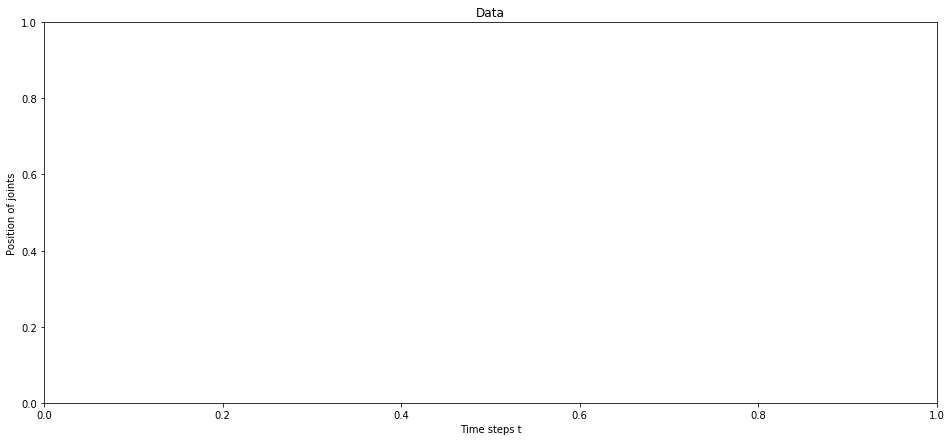

In [88]:
## Making the data plottable ## 
#tensor_to_numpy_trained = callingClass.trained_data_to_numpy
#print("tensor_to_numpy_trained:",tensor_to_numpy_trained)
###########################################################################
################## Plotting the data ######################################
## Figure 1 
plt.figure(figsize=(16,7))
plt.title('Data')
plt.xlabel('Samples')
plt.ylabel('Torque')
#plt.plot(scaled_data,label='Original data')
plt.plot(trained_data_imported,length_sample,label = 'Training data')
#plt.plot(test_data, label = 'Testing data')
plt.legend()
plt.show()

## Figure 2 
#plt.figure(figsize=(16,7))
#plt.title('Error')

* Improve by reducing the window size
* How to get the acutually data as inputs/target (placeholders)?
